# RNN - GRU : 5 epochs and 0.5 of dataset

In [17]:
from common.text_classification_utils import *

dataset = load_dataset()

dataset

,text,CORRECT,NOT_FRENCH,NOT_TRIP,UNKNOWN
0,zrkrwmgseetfegaozv kovx vh,0,0,0,1
1,Comment puis-je me rendre de l'aéroport de CHA...,1,0,0,0
2,4f3;S0`HsL# hL8ydlwlM2cK7=,0,0,0,1
3,"u*]P\UsbAr,CoDnDdr*-GKN(0O",0,0,0,1
4,J'aimerais connaître le chemin pour aller de S...,1,0,0,0
...,...,...,...,...,...
1302960,Il a prétendu être mon ami.,0,0,1,0
1302961,I am planning a trip from saint paul les dax t...,0,1,0,0
1302962,Go from the train station of Loches to Venarey...,0,1,0,0
1302963,Je souhaiterais aller à verneuil sur serre dep...,1,0,0,0


In [18]:
labels, id2label, label2id = prepare_labels(dataset)

['CORRECT', 'NOT_FRENCH', 'NOT_TRIP', 'UNKNOWN']


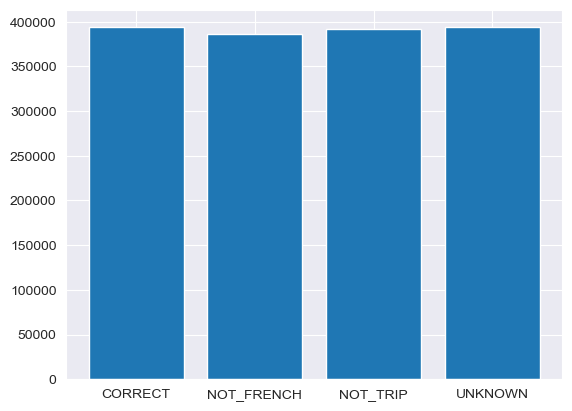

In [19]:
show_labels_distribution(dataset, labels)

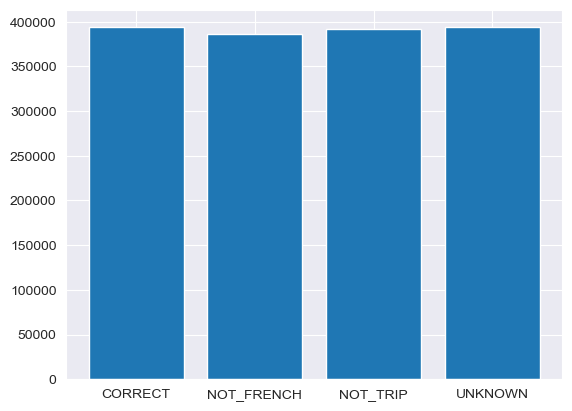

In [20]:
dataset = flatten_trips_labels(dataset)

show_labels_distribution(dataset, labels)

In [21]:
from sklearn.model_selection import train_test_split
# Shuffle train dataset, and pick 50% of it
dataset = dataset.sample(frac=0.5, random_state=0)
X_train = dataset['text']
y_train = dataset[labels]

# To check how vectorizer works without UNKNOWN words being isolated
X_train_without_unknown = dataset[dataset['UNKNOWN'] == 0]['text']
y_train_without_unknown = dataset[dataset['UNKNOWN'] == 0][labels]

# Split test dataset into 10% validation and 10% test
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

print(X_train.shape, X_test.shape, X_val.shape)
print(y_train.shape, y_test.shape, y_val.shape)

(521185,) (65148,) (65149,)
(521185, 4) (65148, 4) (65149, 4)


In [22]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Paramètres de tokenisation
vocab_size = 20000  # Choisissez une taille adaptée à votre vocabulaire
max_length = 100    # Longueur maximale des séquences

# Initialisation du tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Conversion des textes en séquences de tokens
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_val_sequences = tokenizer.texts_to_sequences(X_val)

# Padding des séquences pour qu'elles aient la même longueur
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length)
X_val_padded = pad_sequences(X_val_sequences, maxlen=max_length)

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense

embedding_dim = 128
gru_units = 64

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(GRU(gru_units))
model.add(Dense(4, activation='sigmoid'))  # Ajustez à 4 pour quatre labels

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 128)          2560000   
                                                                 
 gru_1 (GRU)                 (None, 64)                37248     
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 2,597,508
Trainable params: 2,597,508
Non-trainable params: 0
_________________________________________________________________


In [24]:
num_epochs = 5
model.fit(X_train_padded, y_train, epochs=num_epochs, validation_data=(X_val_padded, y_val))


Epoch 1/5
16288/16288 [==============================] - 324s 20ms/step - loss: 0.0096 - accuracy: 0.8670 - val_loss: 0.0045 - val_accuracy: 0.8602
Epoch 2/5
16288/16288 [==============================] - 321s 20ms/step - loss: 0.0030 - accuracy: 0.8650 - val_loss: 0.0037 - val_accuracy: 0.9058
Epoch 3/5
16288/16288 [==============================] - 323s 20ms/step - loss: 0.0026 - accuracy: 0.8893 - val_loss: 0.0038 - val_accuracy: 0.8945
Epoch 4/5
16288/16288 [==============================] - 326s 20ms/step - loss: 0.0024 - accuracy: 0.8706 - val_loss: 0.0037 - val_accuracy: 0.8678
Epoch 5/5
16288/16288 [==============================] - 324s 20ms/step - loss: 0.0022 - accuracy: 0.8765 - val_loss: 0.0039 - val_accuracy: 0.8619


In [25]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test_padded)
threshold = 0.5
y_pred_binary = (y_pred > threshold).astype(int)

print(classification_report(y_test, y_pred_binary, target_names=labels))

2036/2036 [==============================] - 14s 7ms/step
              precision    recall  f1-score   support

     CORRECT       1.00      1.00      1.00     19701
  NOT_FRENCH       1.00      1.00      1.00     19311
    NOT_TRIP       1.00      1.00      1.00     19478
     UNKNOWN       1.00      1.00      1.00     19762

   micro avg       1.00      1.00      1.00     78252
   macro avg       1.00      1.00      1.00     78252
weighted avg       1.00      1.00      1.00     78252
 samples avg       1.00      1.00      1.00     78252



C:\Users\nathp\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
print("Distribution des labels dans l'ensemble d'entraînement :")
print(y_train.sum(axis=0))  # Somme pour chaque label dans y_train

print("\nDistribution des labels dans l'ensemble de test :")
print(y_test.sum(axis=0))   # Somme pour chaque label dans y_test


Distribution des labels dans l'ensemble d'entraînement :
CORRECT       157395
NOT_FRENCH    154421
NOT_TRIP      156746
UNKNOWN       157441
dtype: int64

Distribution des labels dans l'ensemble de test :
CORRECT       19701
NOT_FRENCH    19311
NOT_TRIP      19478
UNKNOWN       19762
dtype: int64


In [27]:
from sklearn.metrics import classification_report
import numpy as np

for threshold in np.arange(0.1, 0.9, 0.1):
    y_pred_binary = (y_pred > threshold).astype(int)
    print(f"Seuil: {threshold}")
    print(classification_report(y_test, y_pred_binary, target_names=labels))


Seuil: 0.1
              precision    recall  f1-score   support

     CORRECT       1.00      1.00      1.00     19701
  NOT_FRENCH       0.99      1.00      1.00     19311
    NOT_TRIP       1.00      1.00      1.00     19478
     UNKNOWN       0.99      1.00      1.00     19762

   micro avg       1.00      1.00      1.00     78252
   macro avg       1.00      1.00      1.00     78252
weighted avg       1.00      1.00      1.00     78252
 samples avg       1.00      1.00      1.00     78252

Seuil: 0.2
              precision    recall  f1-score   support

     CORRECT       1.00      1.00      1.00     19701
  NOT_FRENCH       1.00      1.00      1.00     19311
    NOT_TRIP       1.00      1.00      1.00     19478
     UNKNOWN       1.00      1.00      1.00     19762

   micro avg       1.00      1.00      1.00     78252
   macro avg       1.00      1.00      1.00     78252
weighted avg       1.00      1.00      1.00     78252
 samples avg       1.00      1.00      1.00     78252



C:\Users\nathp\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nathp\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nathp\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     CORRECT       1.00      1.00      1.00     19701
  NOT_FRENCH       1.00      1.00      1.00     19311
    NOT_TRIP       1.00      1.00      1.00     19478
     UNKNOWN       1.00      1.00      1.00     19762

   micro avg       1.00      1.00      1.00     78252
   macro avg       1.00      1.00      1.00     78252
weighted avg       1.00      1.00      1.00     78252
 samples avg       1.00      1.00      1.00     78252

Seuil: 0.4
              precision    recall  f1-score   support

     CORRECT       1.00      1.00      1.00     19701
  NOT_FRENCH       1.00      1.00      1.00     19311
    NOT_TRIP       1.00      1.00      1.00     19478
     UNKNOWN       1.00      1.00      1.00     19762

   micro avg       1.00      1.00      1.00     78252
   macro avg       1.00      1.00      1.00     78252
weighted avg       1.00      1.00      1.00     78252
 samples avg       1.00      1.00      1.00     78252

Seuil: 0.5


C:\Users\nathp\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nathp\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nathp\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
indices = np.random.choice(range(len(y_test)), 10, replace=False)  # Choisir 10 échantillons au hasard
for i in indices:
    print("Vrai label:", y_test.iloc[i].to_list())
    print("Prédiction:", y_pred_binary[i])
    print()


Vrai label: [0, 0, 0, 1]
Prédiction: [0 0 0 1]

Vrai label: [0, 0, 0, 1]
Prédiction: [0 0 0 1]

Vrai label: [0, 1, 1, 0]
Prédiction: [0 1 1 0]

Vrai label: [0, 0, 0, 1]
Prédiction: [0 0 0 1]

Vrai label: [0, 0, 0, 1]
Prédiction: [0 0 0 1]

Vrai label: [0, 0, 0, 1]
Prédiction: [0 0 0 1]

Vrai label: [0, 1, 1, 0]
Prédiction: [0 1 1 0]

Vrai label: [0, 0, 0, 1]
Prédiction: [0 0 0 1]

Vrai label: [0, 0, 0, 1]
Prédiction: [0 0 0 1]

Vrai label: [0, 1, 0, 0]
Prédiction: [0 1 0 0]



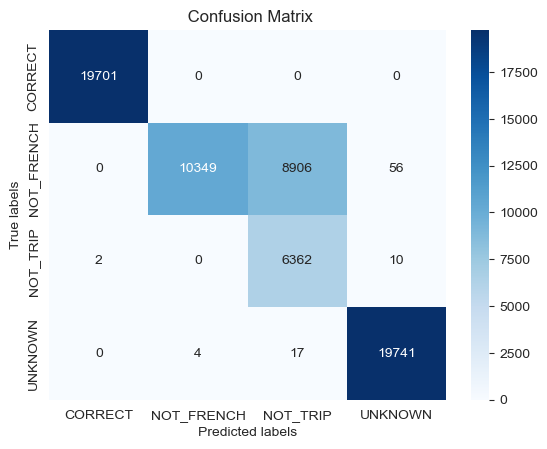

In [29]:
show_confusion_matrix(y_pred, y_test, labels)

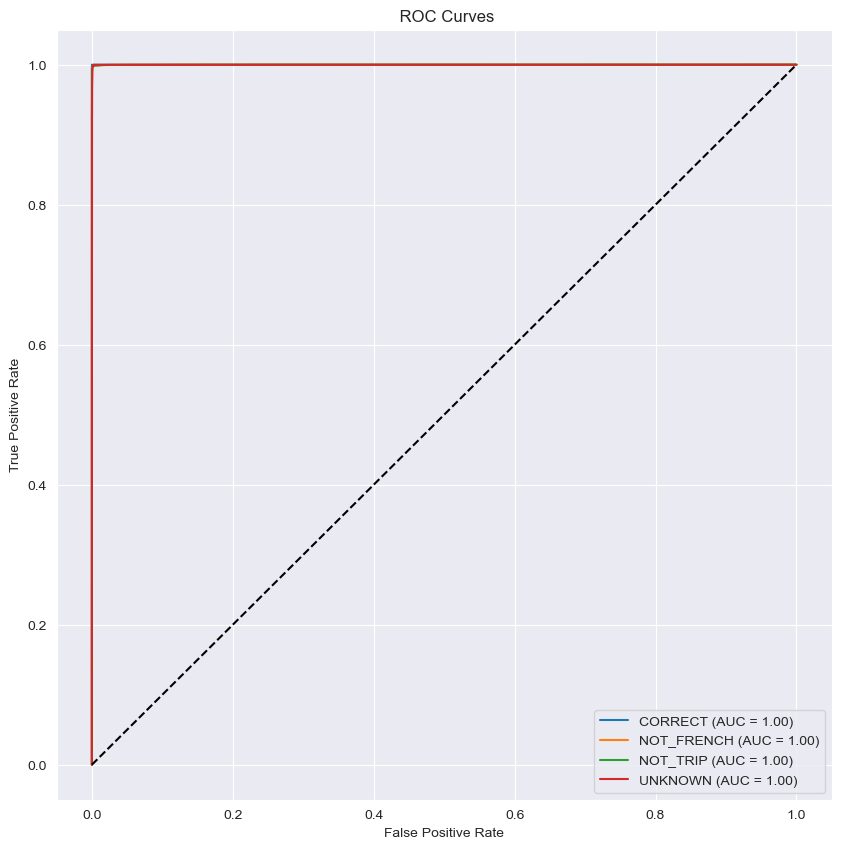

In [30]:
show_roc_curves(labels, y_pred, y_test)

In [31]:
new_texts = [
    "Je veux aller de Port-Boulet à Le Havre.",
    "Je veux aller de Port-Boulet au Havre.",
    "Je vais de Nantes à Paris.",
    "Je vais de Nantes à Nantes.",
    "Je veux aller de Nantes à Nantes.",
    "Je vais à Port-Boulet en partant de Le Havre",
    "Je vais à Port-Boulet en partant du Havre",
    "Peux-tu m'aider à trouver mon chemin vers Paris en partant d'Épierre ?",
    "Je cherche un moyen d'aller de Margny-Lès-Compiègne à Saarbrücken /Sarrebruck.",
    "Je veux me rendre chez mon ami Etienne à Saint-Étienne depuis Nantes.",
    "Je veux aller de la ville de Marseille à Tours.",
    "Recherche le chemin le plus court entre la ville de Lorient et Paris",
    "Trouve-moi un itinéraire pour aller à Besançon depuis la ville d'Oyonnax.",
    "Ca met combien de temps un Toulouse Paris ?",
    "C'est quoi le trajet de Troyes à Niort ?",
    "Comment aller à Niort depuis Troyes ?",
    "Comment aller à Niort depuis Troyes",
    "Recherche un itinéraire de Nantes à Paris où habite Théo",
    "Trouve-moi le chemin le plus rapide vers Paris depuis Nantes pour arriver chez Michel.",
    "Il y a-t-il des trains de Nantes à Montaigu"
]
new_texts_sequences = tokenizer.texts_to_sequences(new_texts)
new_texts_padded = pad_sequences(new_texts_sequences, maxlen=max_length)

predicted_labels = model.predict(new_texts_padded)

# Affichage des labels prédits
for i, text in enumerate(new_texts):
    print(f"Text: {text}")
    print("Predicted labels:")
    for j, label in enumerate(labels):
        print(f" - {label}: {round(predicted_labels[i][j] * 100, 2)}%")

ValueError: in user code:

    File "C:\Users\nathp\anaconda3\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\nathp\anaconda3\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\nathp\anaconda3\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\nathp\anaconda3\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "C:\Users\nathp\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\nathp\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 232, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer "sequential_2" "                 f"(type Sequential).
    
    Input 0 of layer "gru_1" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 128)
    
    Call arguments received by layer "sequential_2" "                 f"(type Sequential):
      • inputs=tf.Tensor(shape=(None,), dtype=string)
      • training=False
      • mask=None
